<a href="https://colab.research.google.com/github/gagan-iitb/DS-503/blob/main/Handouts/NeuralNetPyTorch_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's learn to create vectors, matrices and functions and compute their gradients automatically
https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95
https://d2l.ai/chapter_preliminaries/autograd.html




# Gradient Calculation

In [ ]:
import torch

x = torch.arange(10.0)
x

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Note: By PyTorch’s design, gradients can only be calculated for floating point tensors which is why I’ve created a float type numpy array before making it a gradient enabled PyTorch tensor

gradient of a scalar-valued function with respect to a vector  x  is itself vector-valued and has the same shape as  x .

In [ ]:
x.requires_grad_(True)  # Same as `x = torch.arange(10.0, requires_grad=True)` # start tracking every operation on x and building a backward graph to compute gradients
x.grad  # The default value is None

In [ ]:
y = 2 * torch.dot(x, x)    # y is now a scalar valued function of a vector x
y

tensor(570., grad_fn=<MulBackward0>)

In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36.])

The gradient of the function  y=2x⊤x  with respect to  x  should be  4x . Let us quickly verify that our desired gradient was calculated correctly.

In [ ]:
x.grad == 4 * x

tensor([True, True, True, True, True, True, True, True, True, True])

Autograd: This class is an engine to calculate derivatives (Jacobian-vector product to be more precise). It records a graph of all the operations performed on a gradient enabled tensor and creates an acyclic graph called the dynamic computational graph. The leaves of this graph are input tensors and the roots are output tensors. Gradients are calculated by tracing the graph from the root to the leaf and multiplying every gradient in the way using the chain rule.

grad: grad holds the value of gradient. If requires_grad is False it will hold a None value. Even if requires_grad is True, it will hold a None value unless .backward() function is called from some other node. For example, if you call out.backward() for some variable out that involved x in its calculations then x.grad will hold ∂out/∂x.

In [ ]:
# PyTorch accumulates the gradient in default, we need to clear the previous values
x.grad.zero_()

# New function definition 
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Neural networks are nothing more than composite mathematical functions that are delicately tweaked (trained) to output the required result. The tweaking or the training is done through a remarkable algorithm called backpropagation. Backpropagation is used to calculate the gradients of the loss with respect to the input weights to later update the weights and eventually reduce the loss.

# Activation Functions

In [ ]:
pip install -U d2l

     |████████████████████████████████| 83 kB 1.5 MB/s 


In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

### RELU Activation Function

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
y.backward(torch.ones_like(x), retain_graph=True)

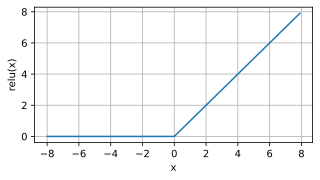

In [ ]:
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

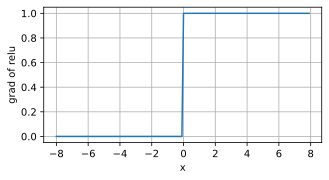

In [ ]:
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))



### Tanh activation function



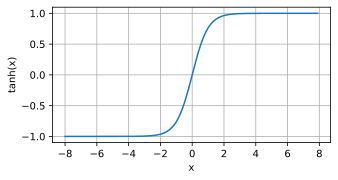

In [ ]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

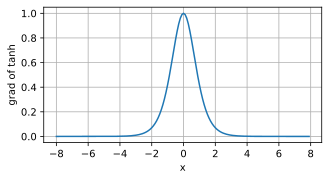

In [ ]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# Softmax Regression and Cross Entropy Loss

# F-MNIST Classification

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_iter

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


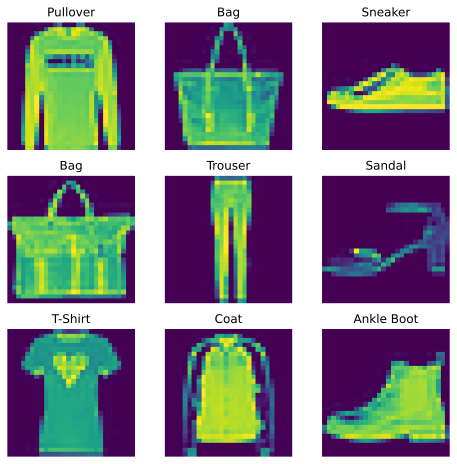

In [ ]:
# Display image and label.
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  train_features, train_labels = next(iter(train_iter))
  img = train_features[0].squeeze()
  label = train_labels[0]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label.item()])
  plt.axis("off")
  plt.imshow(img.squeeze())
plt.show()

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)  # Here '@' stands for matrix multiplication
    return (H @ W2 + b2)

In [ ]:
loss = nn.CrossEntropyLoss()

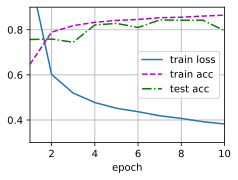

In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


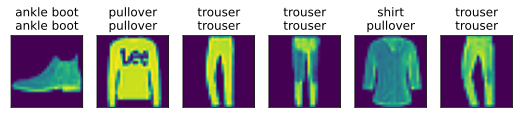

In [ ]:
d2l.predict_ch3(net, test_iter)